In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
df=pd.read_csv("data/xgboost_perfomance.csv")
df=df.loc[~df['experiment_name'].astype(str).str.contains('random search for')]
df_new=pd.read_csv("data/xgboost_perfomance_for_groups.csv")
df=pd.concat([df,df_new], sort=False)

In [2]:
working_time={
    'grid search':3213.38,
    'random params':3128.28,
    'random params in group 1':1248.66,
    'random params in group 2':844.19,
    'random params in group 3':745.66,
    'default params':48.90
}

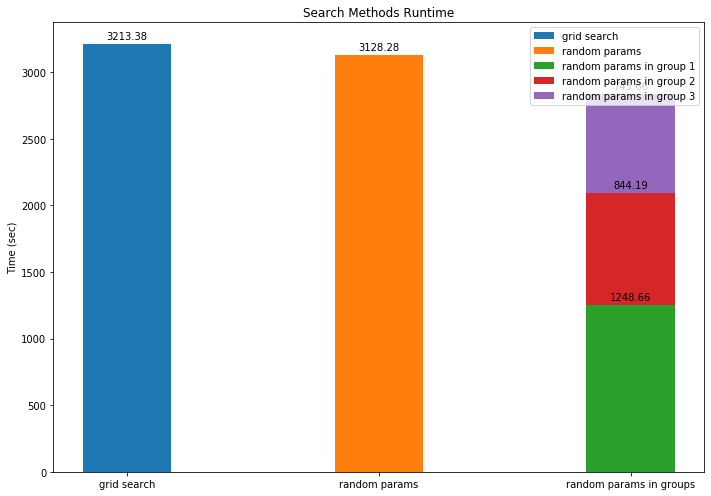

In [3]:
def autolabel(rects, add=0):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()+add
        ax.annotate('{}'.format(round(height-add,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
x = np.arange(3)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,7))

labels=['grid search','random params', 'random params in groups']
rects1 = ax.bar(0, working_time['grid search'], width, label='grid search')
rects2 = ax.bar(1, working_time['random params'], width, label='random params')

rects3_1 = ax.bar(2, working_time['random params in group 1'], width, label='random params in group 1')
rects3_2 = ax.bar(2, working_time['random params in group 2'], width,
             bottom=working_time['random params in group 1'], label='random params in group 2')
rects3_3 = ax.bar(2, working_time['random params in group 3'], width,
             bottom=working_time['random params in group 2'] + working_time['random params in group 1'], 
                  label='random params in group 3')



ax.set_ylabel('Time (sec)')
ax.set_title('Search Methods Runtime')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)
autolabel(rects3_1)
autolabel(rects3_2, working_time['random params in group 1'])
autolabel(rects3_3, working_time['random params in group 1']+working_time['random params in group 2'])
fig.tight_layout()

plt.savefig("graphs/1_time_exec.jpg")
plt.show()

In [4]:
df['iter_num']=0
for experiment in df.loc[:,'experiment_name'].unique():
    df.loc[df['experiment_name']==experiment, 'iter_num']=range(1,df.loc[df['experiment_name']==experiment].shape[0]+1)

In [5]:
top5=df.loc[:,['experiment_name','params','mean_test_score']].sort_values(by='mean_test_score',ascending=False)[:5]

In [6]:
top5

,experiment_name,params,mean_test_score
36,random search for 2 group,"{'alpha': 0.03883801584520204, 'gamma': 0.3309...",0.663592
40,random search for 2 group,"{'alpha': 0.0622279224970861, 'gamma': 0.29728...",0.663592
51,random search for 2 group,"{'alpha': 0.031328773853262215, 'gamma': 0.261...",0.663592
50,random search for 2 group,"{'alpha': 0.02103363450008753, 'gamma': 0.3716...",0.663592
49,random search for 2 group,"{'alpha': 0.09477561708160642, 'gamma': 0.0162...",0.663592


In [7]:
for elem in top5.loc[:,'params']:
    print(elem)

{'alpha': 0.03883801584520204, 'gamma': 0.3309936575531114, 'lambda': 0.09327075147639015}
{'alpha': 0.0622279224970861, 'gamma': 0.2972816589603684, 'lambda': 0.06021788369023793}
{'alpha': 0.031328773853262215, 'gamma': 0.2615148600108993, 'lambda': 0.010832273090061961}
{'alpha': 0.02103363450008753, 'gamma': 0.37166359806727517, 'lambda': 0.04138082490617159}
{'alpha': 0.09477561708160642, 'gamma': 0.016267730729862817, 'lambda': 0.09899772639320598}


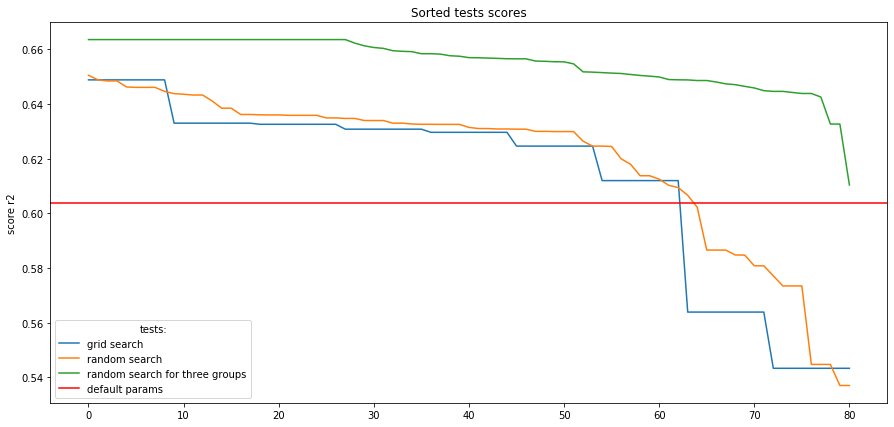

In [8]:
#comparison

name1='grid search'
data1=df.loc[df['experiment_name']==name1, 'mean_test_score'].sort_values(ascending=False)

name2='random search'
data2=df.loc[df['experiment_name']==name2, 'mean_test_score'].sort_values(ascending=False)

name3_1='random search for 1 group'
data3_1=df.loc[df['experiment_name']==name3_1, 'mean_test_score']
name3_2='random search for 2 group'
data3_2=df.loc[df['experiment_name']==name3_2, 'mean_test_score']
name3_3='random search for 3 group'
data3_3=df.loc[df['experiment_name']==name3_3, 'mean_test_score']
name3='random search for three groups'
data3=pd.concat([data3_1,data3_2,data3_3]).sort_values(ascending=False)

name4='default params'
data4=df.loc[df['experiment_name']==name4, 'mean_test_score']

plt.figure(figsize=(15,7))
x=list(range(0, len(data1)))
plt.plot(x, data1, label=name1)
plt.plot(x, data2, label=name2)
plt.plot(x, data3, label=name3)
plt.axhline(data4.values, label=name4, color='r')
plt.legend(title='tests:')
plt.title("Sorted tests scores")
plt.ylabel("score r2")
plt.savefig("graphs/2_scores.jpg")
plt.show()

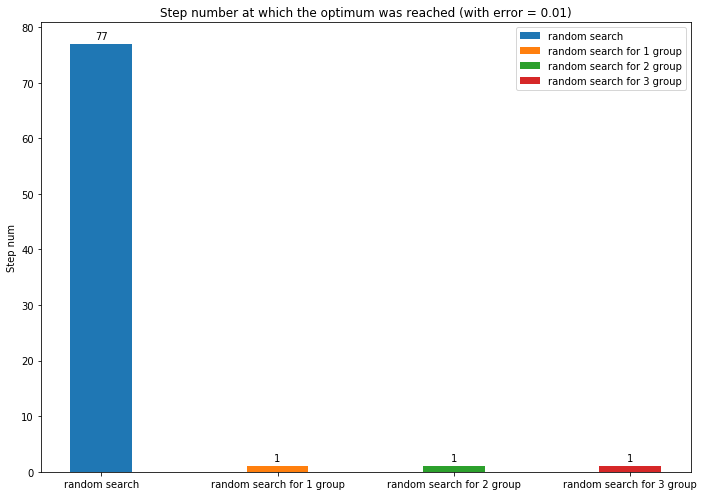

In [9]:
# on which min step algo get best result 
import math
best_res=math.floor(np.max(df.loc[:,'mean_test_score'])*100)/100
best_steps=df.loc[df['mean_test_score']>=best_res-0.01,['experiment_name', 'iter_num']].groupby('experiment_name').min().reset_index()


x = np.arange(best_steps.shape[0])  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,7))

labels=best_steps.loc[:,'experiment_name']
rects=[]
for row in range(best_steps.shape[0]):
    rects.append(ax.bar(row, best_steps.loc[row,'iter_num'], width, label=best_steps.loc[row,'experiment_name']))
    autolabel(rects[row])

ax.set_ylabel('Step num')
ax.set_title('Step number at which the optimum was reached (with error = 0.01)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.savefig("graphs/3_best_step.jpg")
plt.show()

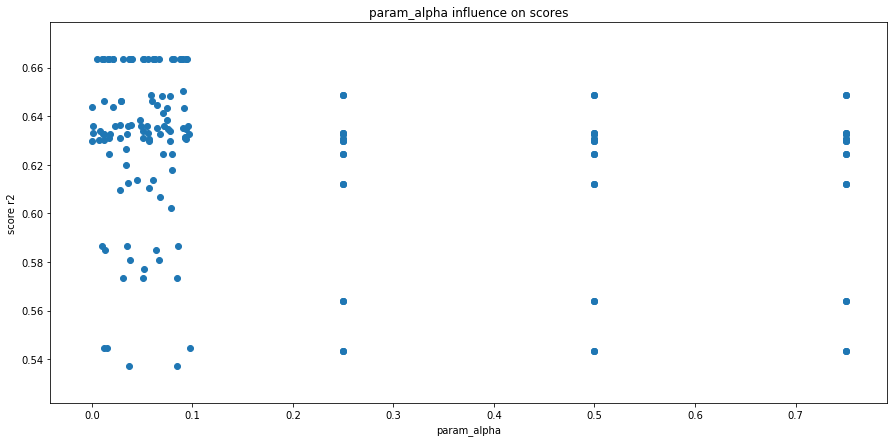

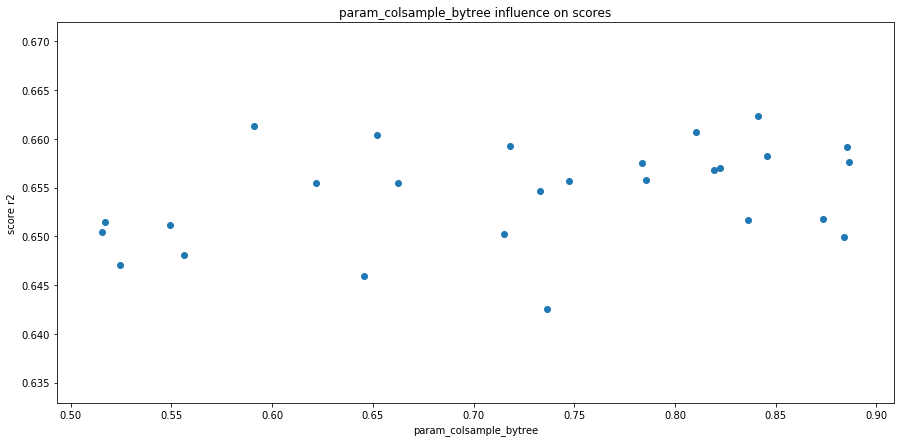

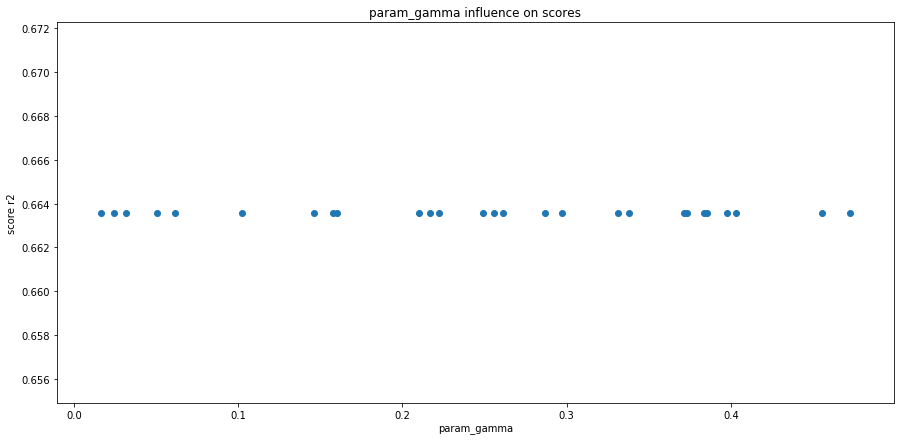

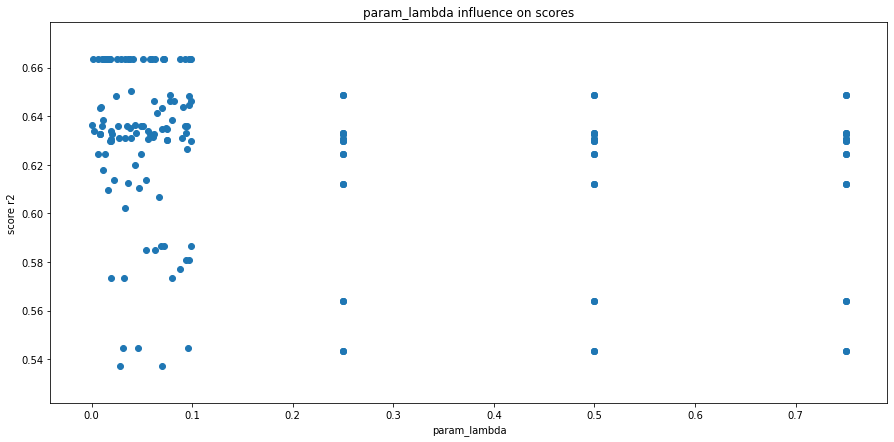

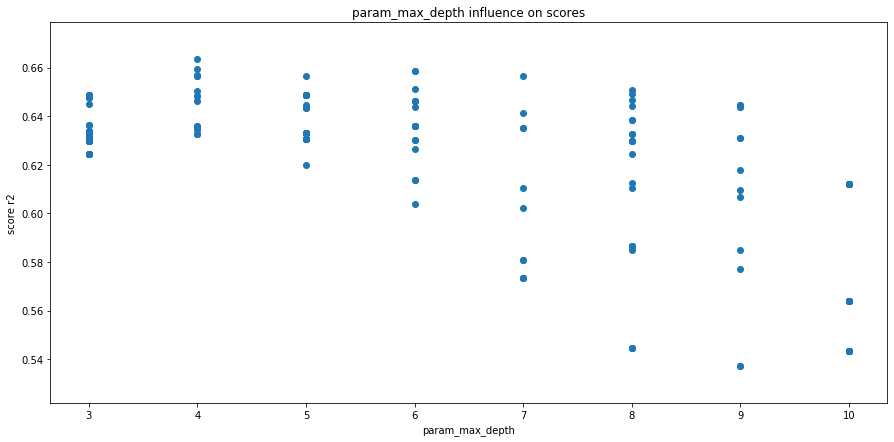

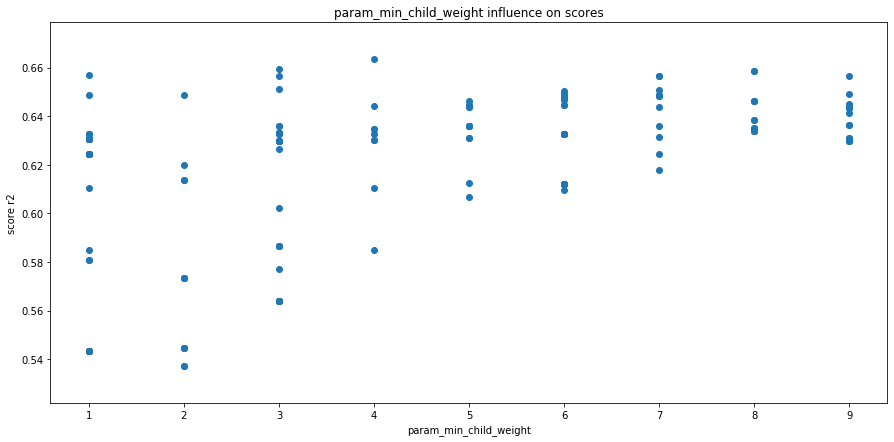

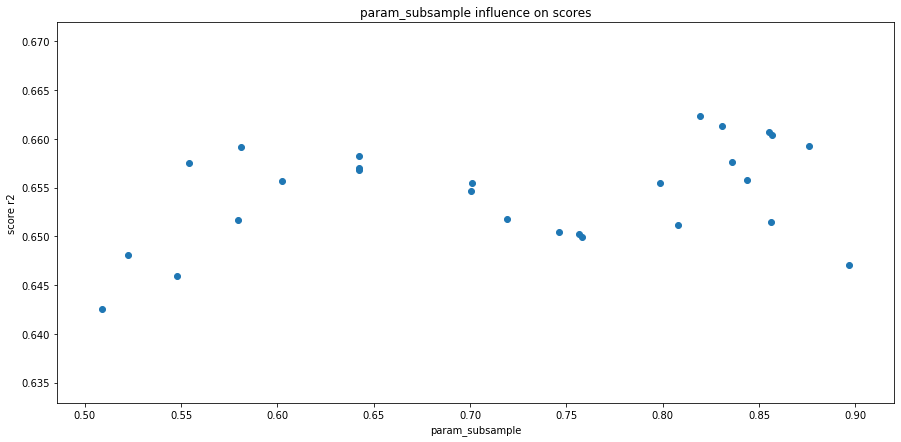

In [10]:
#params influence


params_list=['param_alpha', 'param_colsample_bytree',
       'param_gamma', 'param_lambda', 'param_max_depth',
       'param_min_child_weight', 'param_subsample']

for param in params_list:
    df.loc[:,param].unique().sort

    plt.figure(figsize=(15,7))
    x=df.loc[:,param]
    y=df.loc[:,'mean_test_score']
    plt.scatter(x, y)

    plt.title(param+" influence on scores")
    plt.xlabel(param)
    plt.ylabel("score r2")
    plt.savefig("graphs/4 {} influence.jpg".format(param))
    plt.show()